In [2]:
%%capture
!pip install transformers  pandas scikit-learn

In [1]:
# Install Pytorch & other libraries
%pip install "torch==2.5.0" "torchvision==0.20.0"
%pip install "setuptools<71.0.0" scikit-learn

# Install Hugging Face libraries
%pip install  --upgrade \
  "datasets==3.1.0" \
  "accelerate==1.2.1" \
  "hf-transfer==0.1.8"

# ModernBERT is not yet available in an official release, so we need to install it from github
%pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade


  Cloning https://github.com/huggingface/transformers.git (to revision 6e0515e99c39444caae39472ee1b2fd76ece32f1) to /tmp/pip-req-build-__wg4nf3
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-__wg4nf3
  Running command git rev-parse -q --verify 'sha^6e0515e99c39444caae39472ee1b2fd76ece32f1'
  Running command git fetch -q https://github.com/huggingface/transformers.git 6e0515e99c39444caae39472ee1b2fd76ece32f1
  Running command git checkout -q 6e0515e99c39444caae39472ee1b2fd76ece32f1
  Resolved https://github.com/huggingface/transformers.git to commit 6e0515e99c39444caae39472ee1b2fd76ece32f1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Load training data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_distribution(category):
  """
  A method to show the label distribution
  """
  category_counts = data[category].value_counts()
  plt.figure(figsize=(20,8))

  plt.subplot(1,2,2)
  sns.barplot(x=category_counts.index, y=category_counts.values,palette="Blues_d")
  plt.title(f"{category} Label Distribution")
  plt.xlabel(f"{category} labels")
  plt.ylabel('Count')
  plt.xticks(rotation=45)

  plt.tight_layout()
  plt.show()

<ipython-input-13-e32645c809bc>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values,palette="Blues_d")


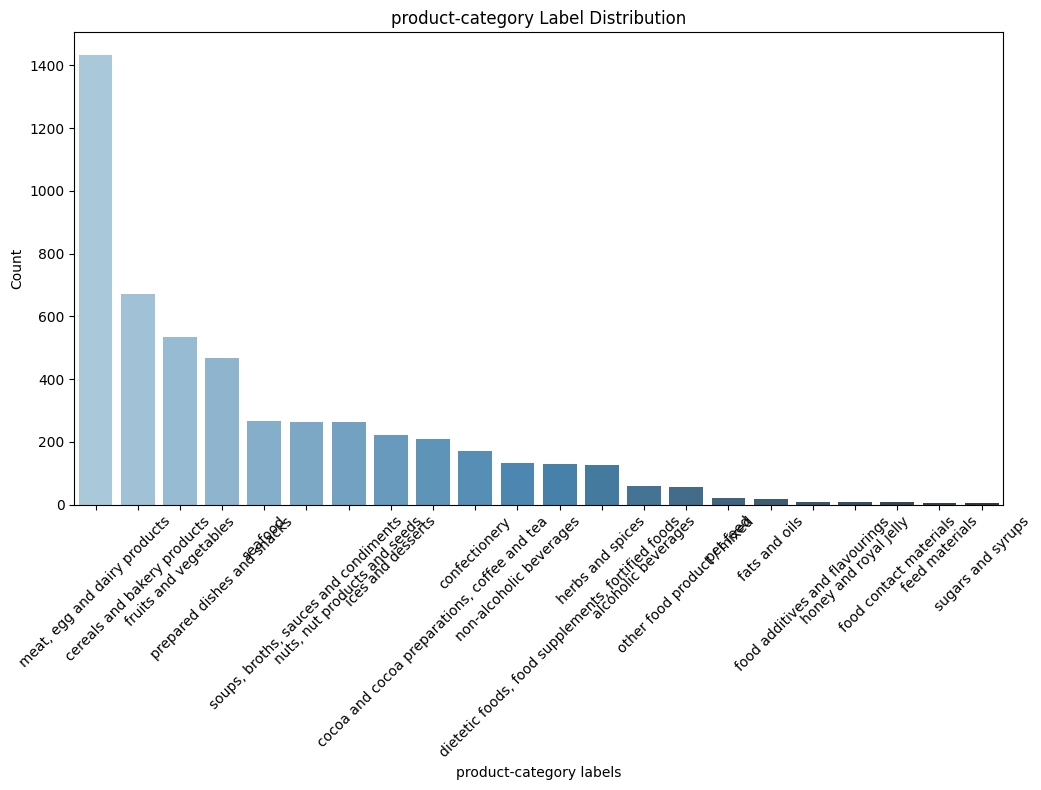

In [ ]:
draw_distribution('product-category')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/augmented_data_2.csv'

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
aug_data = pd.read_csv(file_path)
aug_data.head()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,2003,4,8,au,The Australian Football League—AFL 2003 Auskic...,"APR No. 2003/6086 Release Date April 8, 2003 P...",other hazard,food contact materials,other not classified,plastics
1,2012,3,1,au,Frost Merchandising Pty Ltd—Smiles 4 Miles / D...,Product Category Foods and Groceries × Smile 4...,packaging defect,food contact materials,damaged packaging,plastics
2,2014,2,20,hk,Food Alert - Food Allergen Alert: Stop Consumi...,The CFS took a sample of Lecithin powder from ...,allergens,food additives and flavourings,milk and products thereof,"emulsifiers, stabilizers, thickeners and gelli..."
3,2014,11,6,ca,Beehive brand Corn Syrup recalled due to piece...,Notice This archive of food recalls and allerg...,foreign bodies,sugars and syrups,plastic fragment,syrup
4,2015,10,24,us,2015 - UPC Correction: David Trail Mix Sweet &...,DAVID Trail Mix Sweet & Salty Taste is volunta...,allergens,food additives and flavourings,milk and products thereof,flavours


In [6]:
len(aug_data)

5150

In [7]:
train_df, dev_df = train_test_split(aug_data, test_size=0.2, random_state=2024)

train_df.sample()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
1302,2015,3,23,us,2015 - Blue Bell Ice Cream Recalls 3 oz. Insti...,"Blue Bell Ice Cream of Brenham, Texas, is reca...",biological,ices and desserts,listeria monocytogenes,ice cream


# Focal Loss

In [8]:
# focal loss function
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F


class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.

    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.

        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v!r}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
               gamma: float = 0.,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLoss:
    """Factory function for FocalLoss.

    Args:
        alpha (Sequence, optional): Weights for each class. Will be converted
            to a Tensor if not None. Defaults to None.
        gamma (float, optional): A constant, as described in the paper.
            Defaults to 0.
        reduction (str, optional): 'mean', 'sum' or 'none'.
            Defaults to 'mean'.
        ignore_index (int, optional): class label to ignore.
            Defaults to -100.
        device (str, optional): Device to move alpha to. Defaults to 'cpu'.
        dtype (torch.dtype, optional): dtype to cast alpha to.
            Defaults to torch.float32.

    Returns:
        A FocalLoss object
    """
    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        reduction=reduction,
        ignore_index=ignore_index)
    return fl

In [9]:
focal_loss_fn = FocalLoss(alpha=None, gamma=2, reduction='mean')

# Train and Evaluate BERT

In [10]:
import torch
from transformers import AutoTokenizer, AdamW, get_scheduler, DataCollatorWithPadding
from functools import partial


tokenizer = AutoTokenizer.from_pretrained('answerdotai/ModernBERT-base')
# max_length = tokenizer.model_max_length
# print(f"Model's max tokenization length: {max_length}") 8192

def mask_keywords(text, keywords, default_prompt=None):
    found = False
    for keyword in keywords:
        if keyword in text:
            text = text.replace(keyword, "[MASK]")
            found = True
    if not found and default_prompt:
        text = default_prompt + text
    return text

def tokenize_function(examples, label_type):
    keywords_hazard = ['hazard', 'risk', 'danger', 'safety', 'damage','issue','defect']
    keywords_product = ['product', 'meat','fruit','vegetables','deserts','fat','sugar']

    if label_type == 'hazard-category':
        default_prompt = "This text is about hazards."
        input_text = [mask_keywords(text, keywords_hazard, default_prompt) for text in examples['text']]
    elif label_type == 'product-category':
        default_prompt = "This text is about products."
        input_text = [mask_keywords(text, keywords_product, default_prompt) for text in examples['text']]

    return tokenizer(input_text, padding='max_length', truncation=True, max_length=512)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Data preprocessing function:

In [ ]:
!pip3 install datasets

  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.4 MB/s eta 0:00:00
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached multiprocess-0.70.16-py311-none-any.whl (143 kB)
Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)


In [11]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from datasets import Dataset

def prepare_data(label):
    # encode labels:
    label_encoder = LabelEncoder()
    label_encoder.fit(aug_data[label])

    train_df['label'] = label_encoder.transform(train_df[label])
    dev_df['label'] = label_encoder.transform(dev_df[label])

    # Convert DataFrame to Hugging Face Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)


    # Apply the tokenizer to the dataset

    # Tokenizer without prompt
    # train_dataset = train_dataset.map(tokenize_function, batched=True)
    # dev_dataset = dev_dataset.map(tokenize_function, batched=True)

    train_dataset = train_dataset.map(partial(tokenize_function, label_type=label), batched=True)
    dev_dataset = dev_dataset.map(partial(tokenize_function, label_type=label), batched=True)

    # Create DataCollator to handle padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, max_length=8)

    # Convert dataset to PyTorch format
    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Create DataLoader objects
    return (
        DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator),
        DataLoader(dev_dataset, batch_size=8, collate_fn=data_collator),
        label_encoder
    )

Evaluation function:

In [12]:
from sklearn.metrics import f1_score

def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.

## Sub-Task 1:

### Label: `Hazard Category`

* Data preprocessing

In [13]:

label = 'hazard-category'

# class_weights = compute_class_weight('balanced', classes=np.unique(data[label]), y=data[label])
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to('cuda')  # Move weights to GPU if available
# focal_loss_fn = FocalLoss(alpha=class_weights, gamma=2, reduction='mean')
# Create DataLoader objects
train_dataloader, dev_dataloader, le_hazard_category = prepare_data(label)


Map:   0%|          | 0/4120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1030 [00:00<?, ? examples/s]

* Choose your model

In [14]:
from transformers import AutoModelForSequenceClassification

model_hazard_category = AutoModelForSequenceClassification.from_pretrained('answerdotai/ModernBERT-base', num_labels=len(aug_data[label].unique()))
model_hazard_category.to('cuda')  # Move model to GPU if available

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

* Train it

In [15]:
from tqdm.auto import tqdm


optimizer = AdamW(model_hazard_category.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

model_hazard_category.train()

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize a variable to accumulate loss for the epoch
    num_batches = 0
    for batch in train_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available

        outputs = model_hazard_category(**batch)
        #loss = outputs.loss
        logits = outputs.logits
        labels = batch['labels']
        loss = focal_loss_fn(logits, labels)

        epoch_loss += loss.item()
        num_batches += 1  ##

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    # At the end of each epoch, print the average loss
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Epoch Loss: {avg_epoch_loss}")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1545 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2695: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2695: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch 1/3, Average Epoch Loss: 0.3215971468929461
Epoch 2/3, Average Epoch Loss: 0.06560699860196621
Epoch 3/3, Average Epoch Loss: 0.019615109035382453


* Assess it

In [16]:
from sklearn.metrics import classification_report

model_hazard_category.eval()
total_predictions = []
with torch.no_grad():
    for batch in dev_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available

        outputs = model_hazard_category(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        total_predictions.extend([p.item() for p in predictions])

predicted_labels = le_hazard_category.inverse_transform(total_predictions)
gold_labels = le_hazard_category.inverse_transform(dev_df.label.values)
print(classification_report(gold_labels, predicted_labels, zero_division=0))

dev_df['predictions-hazard-category'] = predicted_labels

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2695: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


                                precision    recall  f1-score   support

                     allergens       0.94      0.97      0.96       369
                    biological       0.98      0.99      0.99       353
                      chemical       0.89      0.97      0.93        61
food additives and flavourings       1.00      0.75      0.86         4
                foreign bodies       0.98      0.96      0.97       116
                         fraud       0.74      0.63      0.68        71
                     migration       1.00      1.00      1.00         3
          organoleptic aspects       0.83      0.83      0.83        12
                  other hazard       0.84      0.68      0.75        31
              packaging defect       0.75      0.90      0.82        10

                      accuracy                           0.94      1030
                     macro avg       0.90      0.87      0.88      1030
                  weighted avg       0.94      0.94      0.94 

In [17]:
model_hazard_category.save_pretrained("bert_hazard_category")
np.save("bert_hazard_category/label_encoder.npy", le_hazard_category.classes_)

### Label: `Product Category`

In [18]:

label = 'product-category'

# class_weights = compute_class_weight('balanced', classes=np.unique(data[label]), y=aug_data[label])
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to('cuda')  # Move weights to GPU if available
# focal_loss_fn = FocalLoss(alpha=None, gamma=2, reduction='mean')

# Create DataLoader objects
train_dataloader, dev_dataloader, le_product_category = prepare_data(label)


Map:   0%|          | 0/4120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1030 [00:00<?, ? examples/s]

* Train

In [19]:

model_product_category = AutoModelForSequenceClassification.from_pretrained('answerdotai/ModernBERT-base', num_labels=len(aug_data[label].unique()))
model_product_category.to('cuda')  # Move model to GPU if available



optimizer = AdamW(model_product_category.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

model_product_category.train()
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize a variable to accumulate loss for the epoch
    num_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available

        outputs = model_product_category(**batch)
        #loss = outputs.loss

        logits = outputs.logits
        labels = batch['labels']
        loss = focal_loss_fn(logits, labels)
        epoch_loss += loss.item()
        num_batches += 1  # Increment the batch counter

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
      # At the end of each epoch, print the average loss
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Epoch Loss: {avg_epoch_loss}")


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1545 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2695: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch 1/3, Average Epoch Loss: 1.221369205342913
Epoch 2/3, Average Epoch Loss: 0.38653512879826346
Epoch 3/3, Average Epoch Loss: 0.09582850757157838


* Test

In [20]:
from sklearn.metrics import classification_report
model_product_category.eval()
total_predictions = []
with torch.no_grad():
    for batch in dev_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available
        outputs = model_product_category(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        total_predictions.extend([p.item() for p in predictions])

predicted_labels = le_product_category.inverse_transform(total_predictions)
gold_labels = le_product_category.inverse_transform(dev_df.label.values)
print(classification_report(gold_labels, predicted_labels, zero_division=0))

dev_df['predictions-product-category'] = predicted_labels

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.93      0.87      0.90        15
                      cereals and bakery products       0.82      0.80      0.81       135
     cocoa and cocoa preparations, coffee and tea       0.69      0.61      0.65        36
                                    confectionery       0.48      0.55      0.52        29
dietetic foods, food supplements, fortified foods       0.79      0.72      0.75        32
                                    fats and oils       0.60      1.00      0.75         3
                   food additives and flavourings       0.50      0.50      0.50         4
                           food contact materials       1.00      0.60      0.75         5
                            fruits and vegetables       0.73      0.80      0.76       115
                                 herbs and spices       0.88      0.67      0.76        2

In [21]:
model_product_category.save_pretrained("bert_product_category")
np.save("bert_product_category/label_encoder.npy", le_product_category.classes_)

## Evaluate Sub-Task

In [22]:
score = compute_score(
    dev_df['hazard-category'], dev_df['product-category'],
    dev_df['predictions-hazard-category'], dev_df['predictions-product-category']
)
print(f"Score Sub-Task 1: {score:.3f}")

Score Sub-Task 1: 0.808
